# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- -----------
absl-py                       1.4.0
aiofiles                      22.1.0
aiosqlite                     0.19.0
alembic                       1.10.4
altair                        4.2.2
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
astunparse                    1.6.3
async-generator               1.10
attrs                         22.2.0
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.2
bleach                        6.0.0
blinker                       1.6.2
bokeh                         3.1.0
boltons                       23.0.0
Bottleneck                    1.3.7
brotlipy                      0.7.0
cached-property               1.5.2
cachetools                    5.3.0
certifi                       2022.12.7
certipy 

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data/MFUlogo/.ipynb_checkpoints


# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 214 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

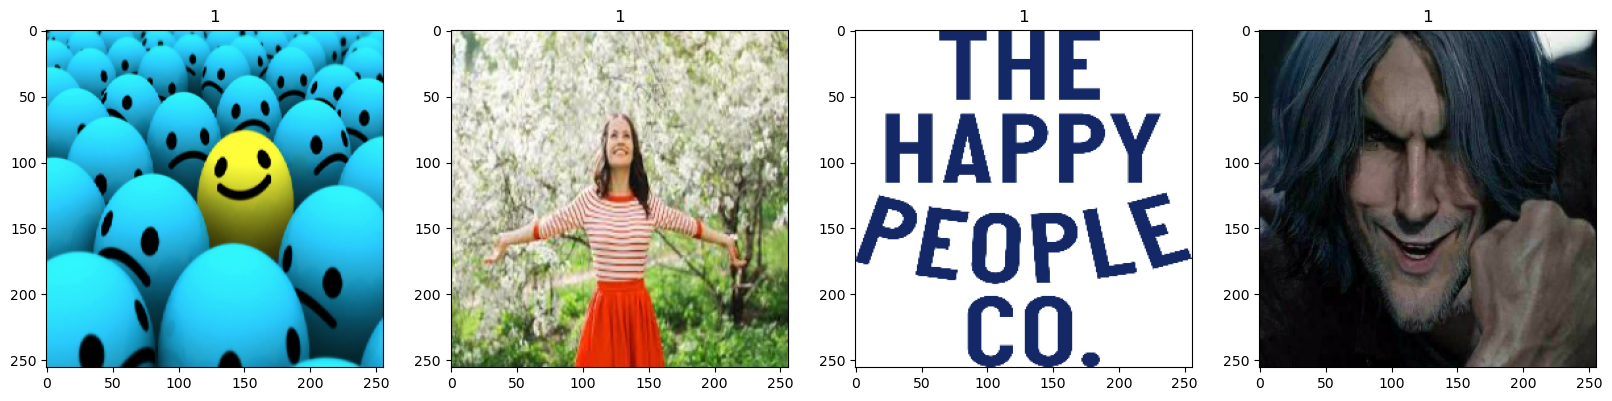

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.52156866, 0.46666667, 0.36078432],
          [0.52156866, 0.46666667, 0.36078432],
          [0.52156866, 0.46666667, 0.36078432],
          ...,
          [0.53128064, 0.48030025, 0.34696692],
          [0.5297488 , 0.47876838, 0.34543505],
          [0.5294118 , 0.47843137, 0.34509805]],
 
         [[0.52156866, 0.46666667, 0.36011028],
          [0.52156866, 0.46666667, 0.36011028],
          [0.52156866, 0.46666667, 0.36011028],
          ...,
          [0.53128064, 0.48030025, 0.34696692],
          [0.5297488 , 0.47876838, 0.34543505],
          [0.5294118 , 0.47843137, 0.34509805]],
 
         [[0.52156866, 0.46666667, 0.35704657],
          [0.52156866, 0.46666667, 0.35704657],
          [0.52156866, 0.46666667, 0.35704657],
          ...,
          [0.53128064, 0.48030025, 0.34696692],
          [0.5297488 , 0.47876838, 0.34543505],
          [0.5294118 , 0.47843137, 0.34509805]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

 5. Split Data

In [20]:
len(data)

7

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [22]:
train_size

4

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

 6. Build Deep Learning Model

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [46]:
model =  tf.keras.models.Sequential()

In [47]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 5.6159e-04 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 7.9200e-04 - accuracy: 1.0000 - val_loss: 6.3836e-04 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 7s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 5.3650e-04 - accuracy: 1.0000 - val_loss: 1.5082e-04 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 1.2311e-04 - accuracy: 1.0000 - val_loss: 3.0533e-04 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 2.4219e-04 - accuracy: 1.0000 - val_loss: 4.0277e-04 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 2.1914e-04 - accuracy: 1.0000 - val_loss: 1.4324e-04 - val_accuracy: 1.00

In [57]:
hist.history

{'loss': [0.003982236608862877,
  0.0007919971831142902,
  0.0017678785370662808,
  0.0005364998942241073,
  0.00012311042519286275,
  0.00024218644830398262,
  0.00021914028911851346,
  0.00012545935169328004,
  0.0002177106507588178,
  8.561727008782327e-05,
  0.00011108061880804598,
  0.0001356977445539087,
  0.0001088741046260111,
  6.790550833102316e-05,
  5.149275966687128e-05,
  5.073570355307311e-05,
  5.244146450422704e-05,
  4.5769495045533404e-05,
  4.257328691892326e-05,
  3.660762376966886e-05],
 'accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.0005615874542854726,
  0.0006383574800565839,
  0.0010242396965622902,
  0.0001508171990280971,
  0.00030533489189110696,
  0.00040276633808389306,
  0.00014323904179036617,
  8.107907342491671e-05,
  0.00020649014913942665,
  6.923608452780172e-05,
  0.00011045728751923889,
  5.324517042026855e-05,
  6.218760245246

# 8. Plot Performance

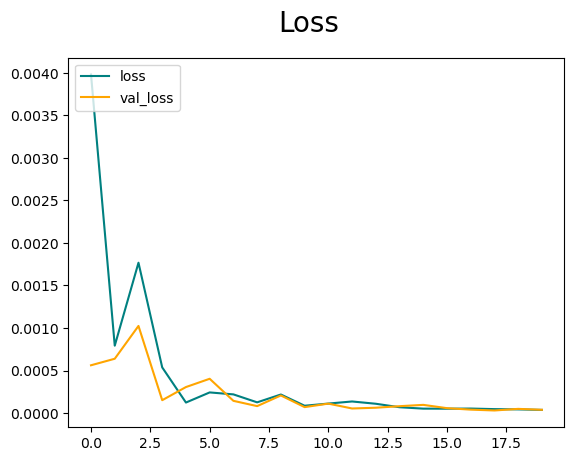

In [58]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

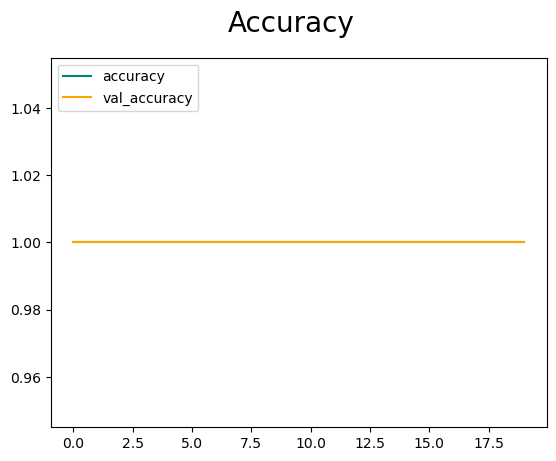

In [59]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [2]:
import cv2
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
model=load_model('./models/logoimageclassifier.h5')

In [3]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [4]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [5]:
len(test)

NameError: name 'test' is not defined

In [6]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: name 'test' is not defined

In [7]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [8]:
import cv2

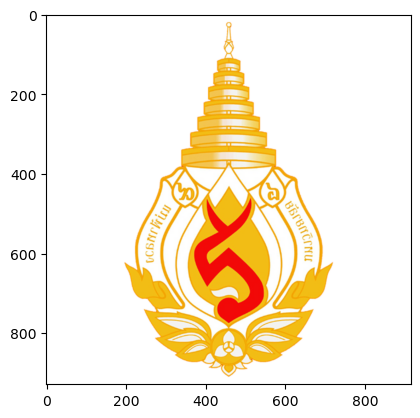

In [29]:
img = cv2.imread('24.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

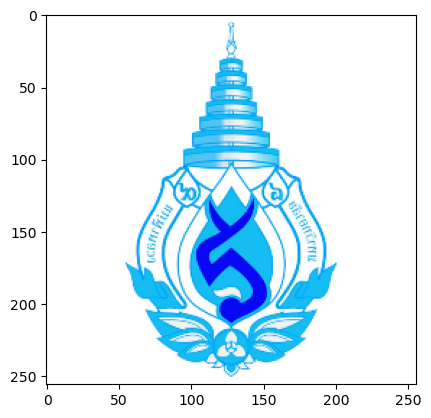

In [30]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
prediction = model.predict(np.expand_dims(resize/256, 0))

1/1 [==============================] - 0s 52ms/step


In [32]:
prediction

array([[0.00063069]], dtype=float32)

In [33]:
if prediction > 0.5: 
    print(f'Predicted class is NotLogo')
else:
    print(f'Predicted class is LogoMFU!!')

Predicted class is LogoMFU!!


# 11. Save the Model

In [67]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.models import load_model

In [68]:
# model.save(os.path.join('models','logoimageclassifier2.csv'))

In [69]:
# new_model = load_model('logoimageclassifier2.h5')

In [70]:
# new_model.predict(np.expand_dims(resize/255, 0))

In [66]:
pip install preprocessing

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import requests
import preprocessing
from PIL import Image
from tensorflow.keras.models import load_model

In [5]:
#model.save(('./models/logoimageclassifier.h5'))

In [6]:
model=load_model('./models/logoimageclassifier.h5')

In [79]:
# weights = model.get_weights()

In [80]:
# weights_array = np.array(weights)

In [81]:
# df = pd.DataFrame(weights_array)
# df.to_csv('logoimageclassifier.csv', index=False)

In [57]:
# !apt-get update
# !apt-get install -y curl
# import subprocess

In [58]:
# website_url="https://www.mfu.ac.th/mfu-landing-page.html"
# curl_command = f'curl -s {website_url}'
# try:
#     html_content = subprocess.check_output(curl_command, shell=True, text=True)
# except subprocess.CalledProcessError as e:
#     print(f"Error retrieving HTML content: {e}")
#     html_content = ""

In [59]:
# import re
# image_urls = re.findall(r'<img[^>]+src="([^"]+)"', html_content)

In [60]:
# for image_url in image_urls:
#     # Extract the image file name from the URL
#     image_filename = image_url.split('/')[-1]

#     # Download the image using curl
#     curl_command = f'curl -o {image_filename} {image_url}'
#     try:
#         subprocess.run(curl_command, shell=True, check=True)
#         print(f'Downloaded: {image_filename}')
#     except subprocess.CalledProcessError as e:
#         print(f"Error downloading {image_url}: {e}")

In [64]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin

In [61]:
website_url = 'https://www.mfu.ac.th/mfu-landing-page.html'

In [65]:
try:
    response = requests.get(website_url)
    response.raise_for_status()
except requests.exceptions.RequestException as e:
    print(f"Error retrieving website: {e}")
    exit(1)

In [66]:
# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all image tags in the HTML
image_tags = soup.find_all('img')

# Create a directory to store the downloaded images
os.makedirs('downloaded_images', exist_ok=True)

# Loop through each image tag and download the image
for image_tag in image_tags:
    # Get the image URL
    image_url = image_tag['src']

    # Handle relative URLs by joining with the website URL
    if not image_url.startswith('http'):
        image_url = urljoin(website_url, image_url)

    # Send a GET request to download the image
    try:
        image_response = requests.get(image_url)
        image_response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {image_url}: {e}")
        continue

    # Extract the filename from the URL
    image_filename = os.path.join('downloaded_images', image_url.split('/')[-1])

    # Save the image to the specified directory
    try:
        with open(image_filename, 'wb') as f:
            f.write(image_response.content)
        print(f'Downloaded: {image_filename}')
    except IOError as e:
        print(f"Error saving image to {image_filename}: {e}")

Downloaded: downloaded_images/cover_info_66-2-01.png
Downloaded: downloaded_images/cover_info_66-2-02.png
Downloaded: downloaded_images/csm_Button_Enter_site_V2-01_a02da562dc.png
Downloaded: downloaded_images/csm_Button_Enter_site_V2-11_665197a483.png
Downloaded: downloaded_images/csm_Button_Enter_site_V2_info_3497faeff8.png
Downloaded: downloaded_images/csm_Button_Enter_site_V2-02_9b6ec2a738.png
Downloaded: downloaded_images/csm_btnTCAS66_adc1d9c609.png


In [48]:
website_url = 'https://www.chula.ac.th/en/'

In [8]:
response = requests.get(website_url)
website_content = response.text

In [10]:
reshaped_data =website_content

In [11]:
predictions = model.predict(reshaped_data)

IndexError: tuple index out of range

In [92]:
predicted_class = yhat.argmax(axis=-1)  # Assuming the model predicts class indices
print('Predicted class:', predicted_class)

Predicted class: [0]
